In [2]:
# =================
# IMPORT LIBRARIES
# =================
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
from time import time


# Read all data and load into files
with h5py.File('/Users/liwenxuan/Desktop/Assignment-1-Dataset/train_128.h5', 'r') as H:
    data = np.copy(H['data'])

with h5py.File('/Users/liwenxuan/Desktop/Assignment-1-Dataset/train_label.h5', 'r') as H:
    label = np.copy(H['label'])

with h5py.File('/Users/liwenxuan/Desktop/Assignment-1-Dataset/test_128.h5', 'r') as H:
    test_data = np.copy(H['data'])

print('train_128.h5: ' + str(data.shape))
print('train_label.h5: ' + str(label.shape))
print('test_128.h5: ' + str(test_data.shape))
print("\n----------------------")

train_128.h5: (60000, 128)
train_label.h5: (60000,)
test_128.h5: (10000, 128)

----------------------


In [3]:
# Transform data to array
input_data = np.array(data, dtype=float)
test_data = np.array(test_data, dtype=float)

# Normalization Data (x-mu)/delta
input_data = (input_data - input_data.mean(axis=0, keepdims=True)) / input_data.std(axis=0, keepdims=True)
test_data = (test_data - test_data.mean(axis=0, keepdims=True)) / test_data.std(axis=0, keepdims=True)

# Transform to one-hot label
label_data = np.array(np.eye(10)[label.reshape(-1)], dtype=float)

In [4]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_derivative(self, a):
        # a = logistic(x)
        return a * (1 - a)

    # define relu activation and relu derivative
    def __relu(self, x):
        index = (x < 0)
        x[index] = 0
        return x

    def __relu_deriv(self, a):
        index1 = (a>=0)
        index0 = np.logical_not(index1)
        a[index1]=1
        a[index0]=0
        return a

    # default activation is relu
    def __init__(self, activation='relu'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_derivative
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv

        # choose relu
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

In [5]:
class InputOuput_Layer(object):
    def __init__(self, n_in, n_out, W=None, b=None, activation='relu', weight_norm=None):
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv

        # so use He initialization
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
        self.b = np.zeros(n_out,)
        self.n_in = n_in
        self.n_out = n_out

        # set whether implement weight normalization
        self.weight_norm = weight_norm
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # batch normalization init gamma and beta
        self.gamma_BN = np.ones((1, n_in))
        self.beta_BN = 0 #np.zeros(n_in,)
        self.grad_gamma_BN = np.ones(self.gamma_BN.shape)
        self.grad_beta_BN = 0 #np.zeros(self.beta_BN.shape)

        # momentum init v and b params
        self.v_w = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)
        # momentum with batch normalization init
        self.v_gamma_BN = np.zeros(self.gamma_BN.shape)
        self.v_beta_BN = 0

    def forward(self, input, BN=False, err_BN=0):
        # judge whether weight normalization and implement
        if self.weight_norm is True:
            self.W = self.W / (((self.W ** 2).sum(axis = 0, keepdims = True)) ** 0.5)
            self.W = np.nan_to_num(self.W)
        # implement forward function and judge whether use activation function
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input
        return self.output

    def forward_predict(self, input, BN=False, err_BN=1e-8):
        # only use it in predict data
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input
        return self.output

    def backward(self, delta):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        # return delta_ for next layer
        return delta_
    
    
    # backward with batch normalization calculate grad_gamma and grad_beta
    # gamma = ∆J/∆y * X ; beta = ∆J/∆y ; ∆J/∆y = y - y_hat because  f_derivative=1
    # formula from: https://chrisyeh96.github.io/2017/08/28/deriving-batchnorm-backprop.html
    # https://arxiv.org/pdf/1502.03167.pdf
    def backward_BN(self, delta):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        # return delta_ for next layer
        return delta_

In [6]:
class HiddenLayer(object):
    def __init__(self, n_in, n_out, W=None, b=None, activation='relu', weight_norm=False, 
                 dropout=False, keep_prob=0.5, weight_decay=False, weight_lambda=0.01):
        # initial stage
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        
        # we use He initialization
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
        self.b = np.zeros(n_out,)
        self.n_in = n_in
        self.n_out = n_out
        
        # set whether implement weight normalization
        self.weight_norm = weight_norm
        
        # set whether implement weight decay and init
        self.weight_decay = weight_decay
        self.weight_lambda = weight_lambda
        
        # set whether implement dropout
        self.dropout = dropout
        if dropout is True:
            print("Using dropout")
        self.keep_prob = keep_prob
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # batch normalization init gamma and beta
        self.gamma_BN = np.ones((1, n_in))
        self.beta_BN = 0 #np.zeros(n_in,)
        self.grad_gamma_BN = np.ones(self.gamma_BN.shape)
        self.grad_beta_BN = 0 #np.zeros(self.beta_BN.shape)
        self.BN_mean_total = []
        self.BN_var_total = []
        
        # momentum init v and b params
        self.v_w = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)
        # momentum with batch normalization init
        self.v_gamma_BN = np.zeros(self.gamma_BN.shape)
        self.v_beta_BN = 0

    def forward(self, input, BN=False, err_BN=1e-8):
        # judge the weight norm and implement
        if self.weight_norm is True:
            self.W = self.W / (((self.W ** 2).sum(axis = 0, keepdims = True)) ** 0.5)
            self.W = np.nan_to_num(self.W)
        # judge the dropout and implement
        if self.dropout is True:
            # set random probability matrix in every double layer
            prob = np.random.rand(input.shape[0], input.shape[1])
            prob = prob < self.keep_prob
            input = input * prob
        # judge whether weight decay and implement
        if self.weight_decay is True:
            self.W = self.W + self.weight_lambda * np.sum(self.W ** 2, axis=0) / 2
        # judge whether normalization and implement
        if BN is True:
            input_mean = input.mean(axis=0, keepdims=True)
            input_var = input.var(axis=0, keepdims=True)
            input = (input - input_mean) / np.sqrt(input_var + err_BN)
            input = input * self.gamma_BN + self.beta_BN
            self.BN_mean_total.append(input_mean)
            self.BN_var_total.append(input_var)
        # calculate this layer output
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input
        return self.output

    def forward_predict(self, input, BN=False, err_BN=1e-8):
        # judge whether batch normalization and implement it use average of all training batches mean and variances
        if BN is True:
            input_mean = np.mean(self.BN_mean_total)
            input_var = np.mean(self.BN_var_total)
            input = (input - input_mean) / np.sqrt(input_var + err_BN)
            input = input * self.gamma_BN + self.beta_BN
            # input = np.dot(input, self.gamma_BN) + self.beta_BN

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input
        return self.output

    # input is from previous layer, it is a_pre
    # delta is dz, delta_ is next layer's delta
    def backward(self, delta):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        # return delta_ for next layer
        return delta_

    # backward with batch normalization calculate grad_gamma and grad_beta
    # gamma = ∆J/∆y * X ; beta = ∆J/∆y ; ∆J/∆y = y - y_hat because  f_derivative=1
    # formula from: https://chrisyeh96.github.io/2017/08/28/deriving-batchnorm-backprop.html
    # https://arxiv.org/pdf/1502.03167.pdf
    def backward_BN(self, delta):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
    
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        
        self.grad_gamma_BN = np.mean(delta_, axis=0, keepdims=True) * self.gamma_BN
        self.grad_beta_BN = np.mean(delta_)
        
        delta__ = delta_ * self.gamma_BN
        # delta__ = np.nan_to_num(delta__)
        # return delta_ for next layer
        return delta__

In [7]:
class MLP(object):
    def __init__(self, input_layers, hidden_layers, output_layers, activation='relu', weight_norm=False, 
                 dropout=False, keep_prob=0.5, output_softmax_crossEntropyLoss=False, weight_decay=False, weight_lambda=0.01):
        # initialize layers
        self.layers = []
        self.params = []

        self.activation = activation
        self.weight_norm = weight_norm

        self.weight_decay = weight_decay
        self.weight_lambda = weight_lambda

        if self.weight_norm is True:
            print("Using weight normalization")

        # init layers
        # firstly add input layer
        self.layers.append(InputOuput_Layer(
            input_layers, hidden_layers[0], activation=activation, weight_norm=weight_norm
        ))
        # secondly add hidden layers if it more than two
        if len(hidden_layers) >= 2:
            for i in range(len(hidden_layers) - 1):
                self.layers.append(HiddenLayer(
                    hidden_layers[i], hidden_layers[i + 1], activation=activation, weight_norm=weight_norm, \
                    dropout=dropout, keep_prob=keep_prob, weight_decay=self.weight_decay, weight_lambda=self.weight_lambda
                ))
        # finally add output layer
        self.layers.append(InputOuput_Layer(
            hidden_layers[-1], output_layers, activation=activation, weight_norm=weight_norm
        ))

        self.output_softmax_crossEntropyLoss = output_softmax_crossEntropyLoss
        if self.output_softmax_crossEntropyLoss is True:
            print("Using softmax and cross entropy loss in output")

    def forward(self, input, BN, err_BN):
        for layer in self.layers:
            output = layer.forward(input, BN, err_BN)
            input = output
        return output

    def forward_predict(self, input, BN=False, err_BN=1e-8):
        # only use it in predict
        for layer in self.layers:
            output = layer.forward_predict(input, BN, err_BN)
            input = output
        return output

    def criterion_MSE(self, y, y_hat):
        if self.output_softmax_crossEntropyLoss is False:
            activation_deriv = Activation(self.activation).f_deriv
            # MSE
            error = y - y_hat
            loss = error**2
            # write down the delta in the last layer
            delta = -error * activation_deriv(y_hat) / 512
            loss = np.sum(loss)

        # softmax and cross entropy loss
        elif self.output_softmax_crossEntropyLoss is True:
            activation_deriv = Activation(self.activation).f_deriv
            exps = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
            # print(np.max(y_hat, axis=0))
            last_y_out = exps / np.sum(exps, axis=1, keepdims=True)
            error = (last_y_out - y)
            loss = -np.sum(y * np.log(last_y_out), axis=1, keepdims=True)
            # write down the delta in the last layer
            delta = error * activation_deriv(y_hat) / 512
        # return loss and delta
        return loss, delta

    def backward(self, delta):
        for layer in reversed(self.layers):
            delta = layer.backward(delta)

    def backward_BN(self, delta):
        # when implement batch normalization use it not above backward function
        for layer in reversed(self.layers):
            delta = layer.backward_BN(delta)

    def update(self, lr, momentum, gamma_MT):
        # Update without momentum
        if momentum is False:
            for layer in self.layers:
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b
        # Update with momentum
        elif momentum is True:
            for i, layer in enumerate(self.layers):
                layer.v_w = gamma_MT * layer.v_w + lr * layer.grad_W
                layer.W -= layer.v_w
                layer.v_b = gamma_MT * layer.v_b + lr * layer.grad_b
                layer.b -= layer.v_b

    def update_BN(self, lr, momentum, gamma_MT):
        # when implement batch normalization use it not above update function
        # Update without momentum
        if momentum is False:
            for layer in self.layers:
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b
                layer.gamma_BN -= lr * layer.grad_gamma_BN
                layer.beta_BN -= lr * layer.grad_beta_BN

        # Update with momentum
        elif momentum is True:
            for i, layer in enumerate(self.layers):
                layer.v_w = gamma_MT * layer.v_w + lr * layer.grad_W
                layer.W -= layer.v_w
                layer.v_b = gamma_MT * layer.v_b + lr * layer.grad_b
                layer.b -= layer.v_b
                layer.v_gamma_BN = gamma_MT * layer.v_gamma_BN + lr * layer.grad_gamma_BN
                layer.gamma_BN -= layer.v_gamma_BN
                layer.v_beta_BN = gamma_MT * layer.v_beta_BN + lr * layer.grad_beta_BN
                layer.beta_BN -= layer.v_beta_BN

    # mini batch training
    def mini_batches_random(self, X, y, mini_batch_size):
        # the feature at columns
        num_samples = X.shape[0]
        mini_batches = []

        permutation = list(np.random.permutation(num_samples))
        rand_X = X[permutation, :]
        rand_y = y[permutation, :]#.reshape(num_samples, 10)

        num_complete = num_samples // mini_batch_size

        for i in range(num_complete):
            mini_batch_X = rand_X[i * mini_batch_size: (i + 1) * mini_batch_size, :]
            mini_batch_y = rand_y[i * mini_batch_size: (i + 1) * mini_batch_size, :]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)

        if num_samples % mini_batch_size != 0:
            mini_batch_X = rand_X[num_complete * mini_batch_size:, :]
            mini_batch_y = rand_y[num_complete * mini_batch_size:, :]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
        return mini_batches

    def fit(self, X, y, learning_rate=0.1, epochs=100, gd='mini_batch', 
            momentum=False, gamma_MT=0.9, mini_batch_size=64, batch_norm=False, err_BN=1e-8):
        X = np.array(X)
        y = np.array(y)
        to_return = np.zeros(epochs)
        self.BN = batch_norm
        if self.BN is True:
            print("Using batch normalization")
        self.err_BN = err_BN
        if momentum is True:
            print('Using momentum')

        # Implement Gradient Descent
        if gd == 'GD':
            print("Using GD")
            for k in range(epochs):
                epoch_start_time = time()
                loss = np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i = np.random.randint(X.shape[0])
                    # forward pass
                    y_hat = self.forward(X[i], batch_norm, err_BN)
                    # backward pass
                    loss[it], delta = self.criterion_MSE(y[i], y_hat)
                    self.backward(delta)
                    # update
                    self.update(learning_rate, momentum, gamma_MT)
                to_return[k] = np.mean(loss)
                epoch_end_time = time()
                print("---------------------------------------\n--- the epoch %s loss: %4f and used: %2f seconds" 
                          % (str(k+1), to_return[k], (epoch_end_time - epoch_start_time)))

        if gd == 'SGD':
            print("Using SGD")
            for k in range(epochs):
                epoch_start_time = time()
                loss = 0
                i = np.random.randint(X.shape[0])
                # forward pass
                y_hat = self.forward(X[i], batch_norm, err_BN)
                # backward pass
                loss, delta = self.criterion_MSE(y[i], y_hat)
                self.backward(delta)
                # update
                self.update(learning_rate, momentum, gamma_MT)
                to_return[k] = np.mean(loss)
                epoch_end_time = time()
                print("---------------------------------------\n--- the epoch %s loss: %4f and used: %2f seconds" 
                          % (str(k+1), to_return[k], (epoch_end_time - epoch_start_time)))

        # Implement Mini Batch
        if gd == 'mini_batch':
            print("Using mini batch")
            print("the mini batch size is {}".format(mini_batch_size))
            for k in range(epochs):
                epoch_start_time = time()
                loss = np.zeros(X.shape[0])
                # seed = k
                mini_batches = self.mini_batches_random(X, y, mini_batch_size)

                for it, mini_batch in enumerate(mini_batches):
                    loss_it = 0
                    (mini_batch_X, mini_batch_y) = mini_batch
                    # forward pass
                    y_hat = self.forward(mini_batch_X, batch_norm, err_BN)
                    # backward pass
                    loss_it, delta = self.criterion_MSE(mini_batch_y, y_hat)
                    loss[it] = np.mean(loss_it)

                    # judge BN
                    if batch_norm is False:
                        self.backward(delta)
                        # update
                        self.update(learning_rate, momentum, gamma_MT)
                    elif batch_norm is True:
                        self.backward_BN(delta)
                        # update
                        self.update_BN(learning_rate, momentum, gamma_MT)

                to_return[k] = np.mean(loss)
                epoch_end_time = time()
                print("---------------------------------------\n--- the epoch %s loss: %4f and used: %2f seconds" 
                          % (str(k+1), to_return[k], (epoch_end_time - epoch_start_time)))
        # return to_return
        return to_return

    def predict(self, x, model):
        x = np.array(x)
        output = model.forward_predict(x, self.BN, self.err_BN)
        # when implement output softmax, do it
        if self.output_softmax_crossEntropyLoss is True:
            exps_out = np.exp(output)
            output = exps_out / np.sum(exps_out, axis=1, keepdims=True)
        return output

In [8]:
def calculateAcc(testLabel, realLabel):
    acc_num = 0
    for i in range(len(testLabel)):
        if (testLabel[i] == realLabel[i]):
            acc_num += 1
    acc = acc_num / len(realLabel)
    print("\n--- the accuracy is: {:.4%}".format(float(acc)))
    return acc


def predict_data(test_data, model):
    predictLabel = model.predict(test_data, model)
    predict_array = np.array(predictLabel)
    predictLabel = (predict_array == predict_array.max(axis=1, keepdims=1)).astype(float)
    predictLabel = [np.where(r == 1)[0][0] for r in predictLabel]
    return predictLabel

In [9]:
def splitData(inputDat, labelData, precentage=0.8):
    data_training_shape = int(inputDat.shape[0] * precentage)

    data_index = np.random.permutation(inputDat.shape[0])
    data_training_index = data_index[:data_training_shape]
    data_testing_index = data_index[data_training_shape:]

    trainDat = inputDat[data_training_index]
    trainLabel = labelData[data_training_index]

    testDat = inputDat[data_testing_index]
    testLabel = labelData[data_testing_index]
    return trainDat, trainLabel, testDat, testLabel

In [10]:
# split data
trainDat, trainLabel, testDat, testLabel = splitData(input_data, label_data, precentage=0.9)
realLabel = [np.where(r == 1)[0][0] for r in testLabel]

Using weight normalization
Using dropout
Using dropout
Using softmax and cross entropy loss in output
Using momentum
Using mini batch
the mini batch size is 512
---------------------------------------
--- the epoch 1 loss: 0.004371 and used: 0.716923 seconds
---------------------------------------
--- the epoch 2 loss: 0.003827 and used: 0.711948 seconds
---------------------------------------
--- the epoch 3 loss: 0.002997 and used: 0.617819 seconds
---------------------------------------
--- the epoch 4 loss: 0.001394 and used: 0.634693 seconds
---------------------------------------
--- the epoch 5 loss: 0.001050 and used: 0.620425 seconds
---------------------------------------
--- the epoch 6 loss: 0.000969 and used: 0.622312 seconds
---------------------------------------
--- the epoch 7 loss: 0.000927 and used: 0.658476 seconds
---------------------------------------
--- the epoch 8 loss: 0.000900 and used: 0.635242 seconds
---------------------------------------
--- the epoch 9

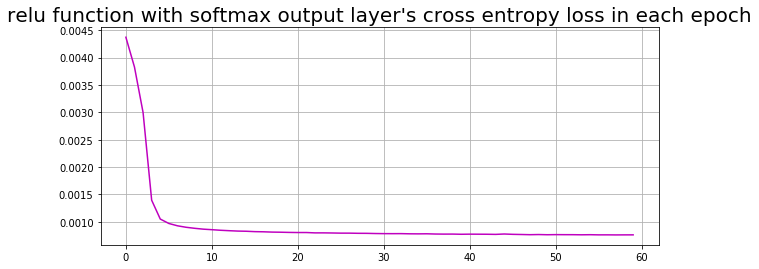

In [93]:
start_relu_time = time()

# Try different MLP models
nn_relu = MLP(input_data.shape[1], [128,128,128], label_data.shape[1], 'relu', weight_norm=True, dropout=True, \
              keep_prob=0.99, output_softmax_crossEntropyLoss=True, weight_decay=True, weight_lambda=0.000005)

# Try different fit models
MSE_relu = nn_relu.fit(trainDat, trainLabel, learning_rate=0.0024, epochs=60, gd='mini_batch', \
                       momentum=True, gamma_MT=0.9, mini_batch_size=512, batch_norm=False)

print("------------------\n")
print('last loss:%f' % MSE_relu[-1])

end_relu_fit_time = time()
print("--- Relu Fit used: %2f seconds" % (end_relu_fit_time - start_relu_time))

pl.figure(figsize=(10,4))
pl.title('relu function with softmax output layer\'s cross entropy loss in each epoch', fontsize=20) 
pl.plot(MSE_relu, color="m")
pl.grid()
pl.show()



In [94]:
# Predict splited test data
predictLabel_relu = predict_data(testDat, nn_relu)
acc_relu = calculateAcc(predictLabel_relu, realLabel)
# build_confusion_matrix(predictLabel_relu, realLabel)


--- the accuracy is: 85.5000%


Using dropout
Using dropout
Using softmax and cross entropy loss in output
Using batch normalization
Using momentum
Using mini batch
the mini batch size is 512
---------------------------------------
--- the epoch 1 loss: 0.002839 and used: 1.026965 seconds
---------------------------------------
--- the epoch 2 loss: 0.002308 and used: 1.012665 seconds
---------------------------------------
--- the epoch 3 loss: 0.002188 and used: 0.947351 seconds
---------------------------------------
--- the epoch 4 loss: 0.002120 and used: 1.046582 seconds
---------------------------------------
--- the epoch 5 loss: 0.002069 and used: 1.015858 seconds
---------------------------------------
--- the epoch 6 loss: 0.002035 and used: 0.974100 seconds
---------------------------------------
--- the epoch 7 loss: 0.002006 and used: 1.101889 seconds
---------------------------------------
--- the epoch 8 loss: 0.001985 and used: 1.110254 seconds
---------------------------------------
--- the epoch 9 

---------------------------------------
--- the epoch 83 loss: 0.001699 and used: 1.251980 seconds
---------------------------------------
--- the epoch 84 loss: 0.001700 and used: 1.235116 seconds
---------------------------------------
--- the epoch 85 loss: 0.001699 and used: 1.262945 seconds
---------------------------------------
--- the epoch 86 loss: 0.001698 and used: 1.290392 seconds
---------------------------------------
--- the epoch 87 loss: 0.001696 and used: 1.117949 seconds
---------------------------------------
--- the epoch 88 loss: 0.001697 and used: 1.059070 seconds
---------------------------------------
--- the epoch 89 loss: 0.001693 and used: 0.991398 seconds
---------------------------------------
--- the epoch 90 loss: 0.001697 and used: 1.084697 seconds
---------------------------------------
--- the epoch 91 loss: 0.001694 and used: 1.058772 seconds
---------------------------------------
--- the epoch 92 loss: 0.001692 and used: 1.091727 seconds
----------

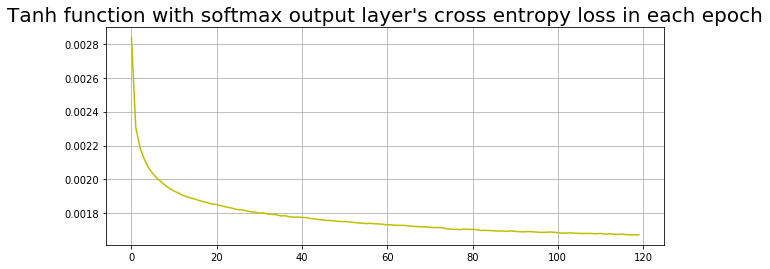

In [15]:
start_tanh_time = time()

# Try different MLP models
nn_tanh = MLP(input_data.shape[1], [128,256,128], label_data.shape[1], 'tanh', weight_norm=False, dropout=True, \
                      keep_prob=0.99, output_softmax_crossEntropyLoss=True, weight_decay=True, weight_lambda=0.0000004)
# Try different fit models
MSE_tanh = nn_tanh.fit(input_data, label_data, learning_rate=0.08, epochs=120, gd='mini_batch', \
                               momentum=True, gamma_MT=0.9, mini_batch_size=512, batch_norm=True)
print("------------------\n")
print('last loss:%f' % MSE_tanh[-1])

end_tanh_fit_time = time()
print("--- Tanh Fit used: %2f seconds" % (end_tanh_fit_time - start_tanh_time))

pl.figure(figsize=(10,4))
pl.title('Tanh function with softmax output layer\'s cross entropy loss in each epoch', fontsize=20) 
pl.plot(MSE_tanh, color="r")
pl.grid()

In [16]:
predictLabel_tanh = predict_data(testDat, nn_tanh)
acc_tanh = calculateAcc(predictLabel_tanh, realLabel)


--- the accuracy is: 97.9500%


In [ ]:
start_result_time = time()


def predictResult(nn = 'nn_2'):
    if nn == 'nn_1':
        nn = MLP(input_data.shape[1], [128,128,128], label_data.shape[1], 'relu', weight_norm=True, dropout=True, \
                      keep_prob=0.99, output_softmax_crossEntropyLoss=True, weight_decay=True, weight_lambda=0.000005)
        MSE = nn.fit(input_data, label_data, learning_rate=0.0024, epochs=60, gd='mini_batch', \
                               momentum=True, gamma_MT=0.9, mini_batch_size=512, batch_norm=False)
    if nn == 'nn_2':
        nn = MLP(input_data.shape[1], [128,256,128], label_data.shape[1], 'tanh', weight_norm=False, dropout=False, \
                      keep_prob=0.5, output_softmax_crossEntropyLoss=True, weight_decay=True, weight_lambda=0.0000004)        
        MSE = nn.fit(input_data, label_data, learning_rate=0.08, epochs=120, gd='mini_batch', \
                               momentum=True, gamma_MT=0.9, mini_batch_size=512, batch_norm=True)
    return nn, MSE


nn, MSE = predictResult(nn = 'nn_1')


print("------------------\n")
print('last loss:%f' % MSE[-1])

end_result_fit_time = time()
print("--- The model Fit used: %2f seconds" % (end_result_fit_time - start_result_time))

pl.figure(figsize=(10,4))
pl.title('the function loss in each epoch') 
pl.plot(MSE, color="r")
pl.grid()
pl.show()

Using weight normalization
Using dropout
Using dropout
Using softmax and cross entropy loss in output
Using momentum
Using mini batch
the mini batch size is 512
---------------------------------------
--- the epoch 1 loss: 0.004394 and used: 0.760018 seconds
---------------------------------------
--- the epoch 2 loss: 0.003741 and used: 0.738018 seconds
---------------------------------------
--- the epoch 3 loss: 0.002042 and used: 0.668154 seconds
---------------------------------------
--- the epoch 4 loss: 0.001104 and used: 0.714382 seconds
---------------------------------------
--- the epoch 5 loss: 0.000997 and used: 0.679591 seconds
---------------------------------------
--- the epoch 6 loss: 0.000949 and used: 0.715566 seconds
---------------------------------------
--- the epoch 7 loss: 0.000918 and used: 0.687363 seconds
---------------------------------------
--- the epoch 8 loss: 0.000898 and used: 0.725566 seconds
---------------------------------------
--- the epoch 9

In [84]:
start_predict_time = time()

predictLabel = predict_data(test_data, nn)

end_predict_time = time()
print("--- The model predict used: %2f seconds" % (end_predict_time - start_predict_time))

output_data = pd.DataFrame(predictLabel)
output_data.to_csv("Predicted_labels.h5", sep=",", index = False, header=False)

--- The model predict used: 0.076156 seconds
